# Trabajo práctico n° 2
## Evolución del salario joven

Integrantes:
- Mazo, Luis
- Hoj, Agustín
- Nacucchio, Illed

El objetivo de este programa es analizar la evolución del salario joven desde el 2007 hasta la actualidad y predecir cómo seguirá evolucionando el año entrante. Además, se propone hacer comparaciones con el salario mínimo correspondiente a la época para hacer deducciones sobre la valoración de cada sector de trabajo. Para ello contamos con tres datasets: uno que contiene los datos sobre el salario en distintos sectores desde el 2007 hasta junio del 2023, otro que contiene los valores de conversión a dólar del peso argentino desde el 2003 a la actualidad, y uno sobre el salario mínimo. Además, contamos con un dataset de apoyo del que extraeremos un diccionario con la información de los sectores de trabajo que se tienen en cuenta.

### Librerías

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

### Preparación de los dataframes

In [2]:
# Primero preparamos el dataframe donde quedará almacenado el dataset sobre salario joven, ofrecido por fuentes gubernamentales.
dfSalarios = pd.read_csv("salario_joven.csv")
dfSalarios.rename(columns={
    'fecha': 'Fecha',
    'clae2': 'Sector',
    'w_median': 'Sueldo Promedio'},
    inplace=True
)

# Previsualización del dataframe
dfSalarios.head()

,Fecha,Sector,Sueldo Promedio
0,2007-01-01,999,687
1,2007-01-01,1,800
2,2007-01-01,2,736
3,2007-01-01,3,1473
4,2007-01-01,5,999


In [3]:
# Generamos un diccionario con la información correspondiente a cada sector de trabajo incluido en el dataset
# Primero cargamos el dataset en un DataFrame
dfSectores = pd.read_csv('clae_agg.csv')

# Creamos un diccionario a partir de las columnas clae2 y clae2_desc, que se corresponden al ID del sector y su nombre
sectores_descripcion = dict(zip(dfSectores['clae2'], dfSectores['clae2_desc']))

# Imprimimos el diccionario resultante
print("Referencias de cada sector: ")
for clave, valor in sectores_descripcion.items():
    print(f"{clave}: {valor}")

Referencias de cada sector: 
1: Agricultura, ganadería, caza y servicios relacionados
2: Silvicultura y explotación forestal
3: Pesca y acuicultura
5: Extracción de carbón y lignito
6: Extracción de petróleo crudo y gas natural
7: Extracción de minerales metálicos
8: Extracción de otros minerales
9: Actividades de apoyo al petróleo y la minería
10: Elaboración de productos alimenticios
11: Elaboración de bebidas
12: Elaboración de productos de tabaco
13: Elaboración de productos textiles
14: Elaboración de prendas de vestir
15: Elaboración de productos de cuero y calzado
16: Elaboración de productos de madera
17: Elaboración de productos de papel
18: Imprentas y editoriales
19: Fabricación de productos de refinación de petróleo
20: Fabricación de sustancias químicas
21: Elaboracion de productos farmacéuticos
22: Fabricación de productos de caucho y plástico
23: Fabricación de productos de vidrio y otros minerales no metálicos
24: Fabricación de metales comunes
25: Fabricación de produc

In [4]:
# Construimos una función para generar un promedio por mes de cada año de la conversión del dólar oficial y dólar blue
def calcular_tasa_promedio_mensual(csv_file, _encoding):
    # Columnas que deseamos leer (en este caso, las dos primeras); son las que necesitamos y las demás generan conflictos en su lectura
    columns_to_read = ['Fecha', 'Último']

    # Cargamos el CSV utilizando solo las columnas especificadas
    dfDolar = pd.read_csv(csv_file, sep=',', encoding=_encoding, usecols=columns_to_read)

    # Convertimos la 'Fecha' a tipo datetime
    dfDolar['Fecha'] = pd.to_datetime(dfDolar['Fecha'], dayfirst=True)
        
    # Convertimos 'Último' a tipo numérico, ignorando los errores
    dfDolar['Último'] = pd.to_numeric(dfDolar['Último'], errors='coerce')
        
    # Por si acaso, eliminamos filas con valores no numéricos
    dfDolar = dfDolar.dropna(subset=['Último'])
        
    # Creamos columnas adicionales para año y mes
    dfDolar['Año'] = dfDolar['Fecha'].dt.year
    dfDolar['Mes'] = dfDolar['Fecha'].dt.month

    # Modificamos el nombre de la columna 'Último'
    dfDolar = dfDolar.rename(columns={'Último': 'Conversión promedio'})

    # Calculamos el promedio mensual de conversión
    promedio_mensual = dfDolar.groupby(['Año', 'Mes'])['Conversión promedio'].mean().reset_index()
    
    return promedio_mensual # Lo devolvemos

In [5]:
# Dólar oficial
promedioOficial = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')
promedioOficial

,Año,Mes,Conversión promedio
0,2007,1,0.324170
1,2007,2,0.322330
2,2007,3,0.322491
3,2007,4,0.323576
4,2007,5,0.324687
...,...,...,...
198,2023,7,0.003754
199,2023,8,0.003129
200,2023,9,0.002860
201,2023,10,0.002860


In [6]:
# Dólar blue
promedioBlue = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')
promedioBlue

,Año,Mes,Conversión promedio
0,2007,1,3.104783
1,2007,2,3.115500
2,2007,3,3.119091
3,2007,4,3.117619
4,2007,5,3.113478
...,...,...,...
198,2023,7,517.710526
199,2023,8,669.318182
200,2023,9,735.750000
201,2023,10,907.875000


In [7]:
def salario_a_dolar_oficial(_df, _tipoDolar):

    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)

    # Crear columnas adicionales para año y mes en dfSalarios
    _df['Año'] = _df['Fecha'].dt.year
    _df['Mes'] = _df['Fecha'].dt.month

    # Unir dfSalarios con el promedio_mensual del dólar
    _df = pd.merge(_df, _tipoDolar, on=['Año', 'Mes'], how='left')

    # Calcular el equivalente del salario en dólares
    _df['Salario en dólar oficial'] = _df['Sueldo Promedio'] * _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop('Fecha', axis=1)
    _df = _df.drop('Conversión promedio', axis=1)

    # Mostrar el DataFrame resultante
    return(_df)

salariosDolarOficial = salario_a_dolar_oficial(dfSalarios, promedioOficial)
salariosDolarOficial

,Sector,Sueldo Promedio,Año,Mes,Salario en dólar oficial
0,999,687,2007,1,222.704491
1,1,800,2007,1,259.335652
2,2,736,2007,1,238.588800
3,3,1473,2007,1,477.501770
4,5,999,2007,1,323.845396
...,...,...,...,...,...
16910,92,193317,2023,1,1060.958845
16911,93,116402,2023,1,638.835340
16912,94,176101,2023,1,966.474306
16913,95,134212,2023,1,736.579858


In [8]:
def salario_a_dolar_Blue(_df, _tipoDolar):

    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)

    # Crear columnas adicionales para año y mes en dfSalarios
    _df['Año'] = _df['Fecha'].dt.year
    _df['Mes'] = _df['Fecha'].dt.month

    # Unir dfSalarios con el promedio_mensual del dólar
    _df = pd.merge(_df, _tipoDolar, on=['Año', 'Mes'], how='left')

    # Calcular el equivalente del salario en dólares
    _df['Salario en dólar Blue'] = _df['Sueldo Promedio'] / _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop('Fecha', axis=1)
    _df = _df.drop('Conversión promedio', axis=1)

    # Mostrar el DataFrame resultante
    return(_df)

salariosDolarBlue = salario_a_dolar_Blue(dfSalarios, promedioBlue)
salariosDolarBlue

,Sector,Sueldo Promedio,Año,Mes,Salario en dólar Blue
0,999,687,2007,1,221.271531
1,1,800,2007,1,257.666993
2,2,736,2007,1,237.053634
3,3,1473,2007,1,474.429352
4,5,999,2007,1,321.761658
...,...,...,...,...,...
16910,92,193317,2023,1,527.173722
16911,93,116402,2023,1,317.427208
16912,94,176101,2023,1,480.225844
16913,95,134212,2023,1,365.994918


# Espacio interactivo

- Conocer el promedio del salario de cada sector por año:

In [9]:
# Interfaz para que el usuario ingrese el sector de trabajo
sector = int(input("Ingresar el Sector de Actividad como figura en su valor numérico:"))

# Transformamos los datos de la columna Fecha a tipo de dato: fecha
dfSalarios['Fecha'] = pd.to_datetime(dfSalarios.Fecha, format='%Y-%m-%d')

# Filtramos por el sector seleccionado los datos de cada año
dfSalariosFiltrado = dfSalarios.loc[dfSalarios['Sector'] == sector]
anio = dfSalariosFiltrado['Fecha'].dt.year

# Agrupamos por año y calculamos el promedio de sueldo entre todos los meses
dfSalariosFiltrado=dfSalariosFiltrado.groupby(anio).mean()
dfSalariosFiltrado.head(20)

,Fecha,Sector,Sueldo Promedio,Año,Mes
Fecha,,,,,
2007,2007-01-06 12:00:00,14.0,1174.166667,2007.0,1.0
2008,2008-01-06 12:00:00,14.0,1494.166667,2008.0,1.0
2009,2009-01-06 12:00:00,14.0,1827.000000,2009.0,1.0
2010,2010-01-06 12:00:00,14.0,2425.250000,2010.0,1.0
2011,2011-01-06 12:00:00,14.0,3322.416667,2011.0,1.0
2012,2012-01-06 12:00:00,14.0,4297.333333,2012.0,1.0
2013,2013-01-06 12:00:00,14.0,5392.000000,2013.0,1.0
2014,2014-01-06 12:00:00,14.0,7190.000000,2014.0,1.0
2015,2015-01-06 12:00:00,14.0,8909.166667,2015.0,1.0


<Axes: xlabel='Fecha'>

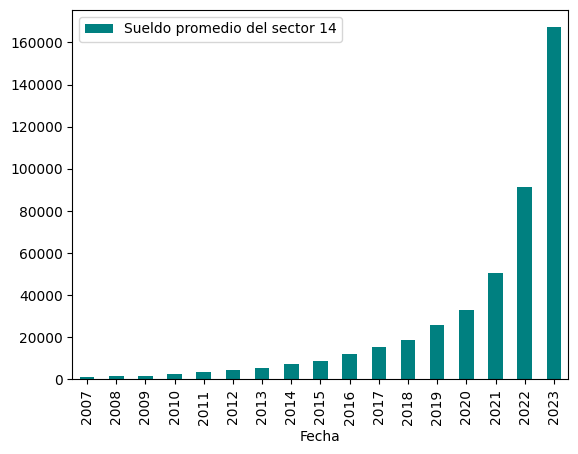

In [10]:
leyenda = "Sueldo promedio del sector " + str(sector)
dfSalariosFiltrado['Sueldo Promedio'].plot.bar(color='teal',legend=True, label=leyenda)

- Calcular conversión de pesos a dólar oficial y blue según el año y el mes elegidos:

In [11]:
# Calculadora
def convertir_a_dolares(monto, año, mes, tasa_promedio_mensual):
    # Filtro el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Verifico si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Realizo la conversión
        monto_en_dolares = monto * tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None

In [12]:
# A dólar oficial
tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')

monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
año_conversion = int(input("El año en el que se desea calcular la conversión:"))
mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
if monto_dolares is not None:
    print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos en cambio oficial el 15/{mes_conversion}/{año_conversion}.')
else:
    print("No se pudo realizar la conversión. Verifica los datos disponibles.")

1000000 pesos argentinos eran aproximadamente 284805.00 dólares americanos en cambio oficial el 15/2/2009.


In [13]:
# A dólar blue
tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
año_conversion = int(input("El año en el que se desea calcular la conversión:"))
mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
if monto_dolares is not None:
    print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
else:
    print("No se pudo realizar la conversión. Verifica los datos disponibles.")

1000000 pesos argentinos eran aproximadamente 3578500.00 dólares americanos blue el 15/2/2009.
